# The Idea
The main idea of this project is to simulate the heating of steak to find the optimal conditions for cooking it to a medium-rare rarity.

# Preamble
We import dependencies and define constants and dictionaries here.

## Importing Packages

In [69]:
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
import math

## Defining Constants

In [50]:
# fat
fat_shc = 1.9842e3 # J kg-1 K-1
fat_tc = 1.8071e-1 # W m-1 K-1
fat_density = 9.2559e2 # kg m-3

# protein
protein_shc = 2.0082e3 # J kg-1 K-1
protein_tc = 1.7881e-1 # W m-1 K-1
protein_density = 1.3299e3 # kg m-3

# water
water_shc = 4.184e3 # J kg-1 K-1
water_tc = 6e-1 # W m-1 K-1
water_density = 9.97e2 # kg m-3

# pixel
pixel_side_length = 0.0025 # meter

# temperatures
max_temperature = 250 # celsius
room_temperature = 25 # celsius
heating_temperature = 230 # celsius
ideal_internal_temperature = 60 # celsius

# temperature thresholds
maillard_temp = 130 # celsius
burnt_temp = 175 # celcius

# composition
fat_percentage = .09
water_percentage = .69
protein_percentage = 1 - fat_percentage - water_percentage

## Defining Dictionaries
In the following we define the `pxl_type` dictionary that map integer numbers to each pixel type as well as a `colors_dict` dictionary that gives us easy access to rbg values of commonly used colors 

In [84]:
pxl_type = {
        "source" : 0,
        "fat" : 1,
        "protein" : 2,
        "water" : 3,
        "maillard" : 4,
        "burnt" : 5
    }

colors_dict = {
        "GOLD" : [153/255,101/255,21/255],
        "BLACK": [0,0,0],
        "RED": [255/255,0,0],
        "RAW_COLOR": [230/255,117/255,122/255], # light pink
        "INNER_COOKED_COLOR": [158/255,155/255,147/255], # grey
        "OUTER_COOKED_COLOR": [94/255,65/255,37/255],
        "FAT": [244/255,180/255,0],
        "WATER": [159/255,197/255,232/255],
        "PROTEIN": [120/255,11/255,17/255]
    }

# Creating a Pixel ADT
Here we define the pixel ADT.\
**Constructor**\
`create_pixel(temperature, thermal_conductivity, specific_heat_capacity, density, pixel_type, outer)` -> pixel\
**Accessors**\
`get_temp(pixel)` -> temperature (float)\
`get_tc(pixel)` -> thermal conductivity (float)\
`get_shc(pixel)` => specific heat capacity (float)\
`get_density(pixel)` -> density (float)\
`get_type(pixel)` -> pixel_type (int)\
`get_outer(pixel)` -> outer layer source or not (int)\
**Modifiers**\
`change_temp(pixel, new_temp)` -> None\
`change_pxl_type(pixel, new_type)` -> None

In [4]:
# =================================
# Constructor
# =================================

def create_pixel(temperature, thermal_conductivity, specific_heat_capacity, density, pxl_type_str, outer):
    return [temperature,
            thermal_conductivity,
            specific_heat_capacity,
            density,
            pxl_type[pxl_type_str],
            outer]

# =================================
# Accessors
# =================================

def get_temp(pixel):
    return pixel[0]

def get_tc(pixel):
    return pixel[1]

def get_shc(pixel):
    return pixel[2]

def get_density(pixel):
    return pixel[3]

def get_type(pixel):
    return pixel[4]

def get_outer(pixel):
    return pixel[5]

# =================================
# Modifiers
# =================================

def change_temp(pxl, new_temp):
    pxl[0] = new_temp

def change_pxl_type(pxl,pxl_type_str):
    pxl[4] = pxl_type[pxl_type_str]

# Creating a Steak
Here we define a function `create_steak` that returns a 2-d list of pixel ADTs with `height` rows and `width` columns.

`create_steak(height, width)` -> 3-d list

This steak will have a randomly distributed composition of water, fat, and protein based on `fat_percentage`, `water_percentage`, and `protein_percentage`.

In [5]:
def create_steak(height, width):
    res = []
    for i in range(height + 1):
        # we define the outer threshold as the 1/8 outer layers of the steak
        outer = True if i < height * 1/8 or i > height * (1 - 1/8) - 1 else False
        tmp = []
        for j in range(width):
            if i < height:
                random_float = random.random()
                # randomly assign pixel type based on composition percentages
                if random_float < fat_percentage:
                    tmp.append(create_pixel(room_temperature,fat_tc,fat_shc, fat_density, "fat", outer))
                elif fat_percentage <= random_float < fat_percentage + water_percentage:
                    tmp.append(create_pixel(room_temperature,water_tc,water_shc, water_density, "water", outer))
                else:
                    tmp.append(create_pixel(room_temperature,protein_tc,protein_shc, protein_density, "protein", outer))
            else:
                # last layer (layer height + 1) is the heat source
                tmp.append(create_pixel(heating_temperature,0,0,0,"source",False))
        res.append(tmp)
    return res

# Changing Temperatures
Here we define a function `step_pixel` that returns the final temperature of a target pixel after a timestep of `t`.

`step_pixel(steak, i, j, timestep)` -> final_temperature (float)

The function first finds the heat gain of the target pixel $Q_{\text{gain}}$ using the following equation:
$$Q_{\text{gain}}=\sum_{i}\left(k_{i,*}\cdot A\cdot\frac{\Delta T_{i,*}}{\Delta x}\cdot t\right)$$
Where
* $k_{i,*}$ is the average thermal conductivity constant between pixel `i` and the pixel of interest,
* $A$ is the surface area of contact between pixels, modelled here as $(\Delta x)^2$,
* $\Delta T_{i,*}$ is $T_i - T_*$ where $T_i$ and $T_*$ is the temperature of the surrounding pixels and the pixel of interest at $t_0$ respectively, and
* $\Delta x$ is the pixel side length

It then finds the change in temperature $\Delta T$ using the following equation:
$$\Delta T = \frac{Q_{\text{gain}}}{\rho\cdot V\cdot c}$$
Where
* $Q_{\text{gain}}$ is the heat gain of the pixel of interest,
* $\rho$ is the density of the pixel of interest,
* $V$ is the volume of pixel of interest, modelled here as $(\Delta x)^3$ and
* $c$ is the specific heat capacity of the pixel of interest

Finally, the final temperature of the pixel of interest, $T_{\text{final}}$ is
$$T_{\text{final}} = T_i + \Delta T$$
  
We also define a function `step`, which applies `step_pixel` to all pixels in a steak.

`step(steak, timestep)` -> None

In [6]:
def step_pixel(steak, i, j, t):

    n_rows = np.shape(steak)[0]
    n_cols = np.shape(steak)[1]

    # ===========================================
    # PART 1: GET THE SURROUNDING PIXEL DATA
    # ===========================================
    top = steak[i-1,j] if i > 0 else None
    bottom = steak[i+1,j] if i < n_rows-1 else None
    left = steak[i,j-1] if j > 0 else None
    right = steak[i,j+1] if j < n_cols-1 else None

    pixels_in_contact = np.array([x for x in [top,left,right,bottom] if x is not None])
    pixel_of_interest = steak[i,j]

    # ===========================================
    # PART 2: CALCULATE HEAT GAIN
    # ===========================================
    temps = np.array(list(get_temp(pixel) for pixel in pixels_in_contact))
    center = get_temp(pixel_of_interest)
    ini_temp_diff = temps - center

    avg_tc_arr = np.zeros(len(pixels_in_contact))
    for idx, pxl in enumerate(pixels_in_contact):
        if get_type(pxl) != pxl_type["source"]:
            avg_tc_arr[idx] = (get_tc(pxl) + get_tc(pixel_of_interest))/2
        else:
            avg_tc_arr[idx] = get_tc(pixel_of_interest)
    
    heat_gain = np.sum(t * avg_tc_arr * pixel_side_length * ini_temp_diff)

    # if i == 0 or j == 0 or j == n_cols-1:
    # if len(pixels_in_contact) != 4:
    #     # accounting lost of heat to surroundings
    #     heat_loss_surr = ((4 - len(pixels_in_contact)) * 
    #                       pixel_side_length * 
    #                       get_tc(pixel_of_interest) * 
    #                       (center - room_temperature) 
    #                       * t)
    #     heat_gain -= heat_loss_surr
    
    # ===========================================
    # PART 3: CALCULATE FINAL TEMPERATURE
    # ===========================================
    vol = pixel_side_length ** 3
    rho = get_density(pixel_of_interest)
    shc = get_shc(pixel_of_interest)
    denom = vol * rho * shc
    change_in_temp = heat_gain / denom

    final_temp = get_temp(pixel_of_interest) + change_in_temp

    return final_temp.item()


def step(steak, timestep):
    height = len(steak)
    width = len(steak[0])

    # create a copy so that the kernel refers to old temp values
    steak_copy_np = np.array(copy.deepcopy(steak))

    for i in range(height):
        for j in range(width):
            pxl = steak[i][j]
            if get_type(pxl) != pxl_type["source"]:
                step_temperature = step_pixel(steak_copy_np, i, j, timestep)
                change_temp(pxl, step_temperature)
                if get_temp(pxl) >= burnt_temp:
                    #set state to burnt
                    change_pxl_type(pxl,"burnt")
                if get_temp(pxl) >= maillard_temp and get_type(pxl) != pxl_type["burnt"]:
                    #set state to maillard
                    change_pxl_type(pxl,"maillard")

# Cooking the Steak
Here we define the function `flip` that flips the steak.

`flip(steak)` -> None

We also define a function `cook` that simulates the cooking of the steak.

`cook(steak, timestep, interval, total_duration)` -> (array_of_steaks, internal_temperature, external_temperature) (list of lists)

This function takes in the following arguments:
* `steak` : 2-d array of pixel ADTs
* `timestep` : Frequency of heating. For example, a timestep of 0.1 means that the steak will be heated 10 separate times in a second.
* `interval` : Time interval between steaks saved in the returned array_of_steaks.
* `total_duration` : Total duration of cooking (in seconds).

Lastly, we define a function `residual` that simulates the residual cooking of steak.

`residual(steak, timestep, total_duration)` -> final_internal_temp (float)

In [88]:
def flip(steak):
    heating = steak.pop(-1)
    steak.reverse()
    steak.append(heating)

def cook(steak,timestep,interval,total_duration):
    n_plots = total_duration // interval
    i = 0
    arr_of_steaks = []
    internal_temperature = []
    external_temperature = []
    print("Processing ... ")
    while i < n_plots:
        j = 0
        while j < (interval / timestep):
            duration = round(timestep * j + i * interval,2)

            # ===========================================
            # Flip steak (every 30s)
            # ===========================================
            if duration % 15 == 0:
                flip(steak)

            # ===========================================
            # Calculate central pixel temperature
            # ===========================================
            internal_temp = get_temp(steak[len(steak)//2][len(steak[0])//2])
            internal_temperature.append(internal_temp)

            # ===========================================
            # Calculate average outer layer temperature
            # ===========================================
            upper_temp = list(map(lambda x : get_temp(x),steak[0]))
            lower_temp = list(map(lambda x : get_temp(x),steak[-2]))
            average_upper_temp = sum(upper_temp)/len(upper_temp)
            average_lower_temp = sum(lower_temp)/len(lower_temp)
            external_temp = (average_upper_temp + average_lower_temp)/2
            external_temperature.append(external_temp)
            
            step(steak,timestep)            

            j += 1

        arr_of_steaks.append(copy.deepcopy(steak))
        i += 1
    print("Done")
    return (arr_of_steaks, internal_temperature, external_temperature)

def residual(steak,timestep,total_duration):
    heating = steak.pop(-1)
    i = 0
    print("Processing ... ")
    while i < total_duration:
        step(steak,timestep)            
        i += timestep
    internal_temp = get_temp(steak[len(steak)//2][len(steak[0])//2])
    print("Done")
    return internal_temp

# Visualising the Steak
In this project, we will visualise the steak from two different aspects:
1. Temperature
2. Composition

**Temperature**
* `to_color(pxl, min_temp, max_temp)` -> rgb_color (1-d 3 element list)
* `get_color_map(steak)` -> color_map (3-d list)

**Composition**
* `to_comp_color(pxl)` -> rgb_color (1-d 3 element list)
* `get_comp_color_map(steak)` -> color_map (3-d list)

In [8]:
def to_color(pxl,min_temp = room_temperature, max_temp = max_temperature):

    temp = get_temp(pxl)

    temp = min_temp if temp < min_temp else max_temp if temp > max_temp else temp

    heat_index = (temp - min_temp)/(max_temp - min_temp)

    if get_type(pxl) == pxl_type["source"]:
        color = colors_dict["RED"]
    elif get_type(pxl) == pxl_type["burnt"]:
        color = colors_dict["BLACK"]
    else:
        if get_outer(pxl):
            raw_color = colors_dict["RAW_COLOR"]
            cooked_color = colors_dict["OUTER_COOKED_COLOR"]
        else:
            raw_color = colors_dict["RAW_COLOR"]
            cooked_color = colors_dict["INNER_COOKED_COLOR"]
        color = list(map(lambda x : (((cooked_color[x] - raw_color[x]) * heat_index) + raw_color[x]),range(3)))
    return color

def get_color_map(steak):
    # steak = list(list(get_temp(pixel) for pixel in row) for row in steak)
    res = []
    for i in range(len(steak)):
        tmp = []
        for j in range(len(steak[0])):
            tmp.append(to_color(steak[i][j]))
        res.append(tmp)
    return res

In [85]:
def to_comp_color(pxl):

    if get_type(pxl) == pxl_type["source"]:
        color = colors_dict["RED"]
    elif get_type(pxl) == pxl_type["fat"]:
        color = colors_dict["FAT"]
    elif get_type(pxl) == pxl_type["water"]:
        color = colors_dict["WATER"]
    elif get_type(pxl) == pxl_type["protein"]:
        color = colors_dict["PROTEIN"]
    return color

def get_comp_color_map(steak):
    res = []
    for i in range(len(steak)):
        tmp = []
        for j in range(len(steak[0])):
            tmp.append(to_comp_color(steak[i][j]))
        res.append(tmp)
    return res

# Analysing Data

In [10]:
steak_one = create_steak(16,30)
arr, internal_temp, external_temp = cook(steak_one,0.1,0.1,1000)

Processing ... 
Done


## Plotting Temperature - Timestep Graph

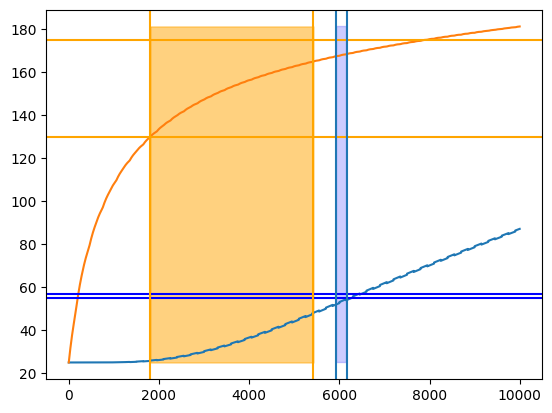

In [11]:
plt.plot(internal_temp)
plt.plot(external_temp)
plt.axhline(55,color="blue")
plt.axhline(57,color="blue")
plt.axhline(130,color="orange")
plt.axhline(175,color="orange")
x_1_external = external_temp.index(min(external_temp, key=lambda x:abs(x-130)))
x_2_external = external_temp.index(min(external_temp, key=lambda x:abs(x-165)))
plt.axvline(x_1_external,color="orange")
plt.axvline(x_2_external,color="orange")
x_1_internal = internal_temp.index(min(internal_temp, key=lambda x:abs(x-52)))
x_2_internal = internal_temp.index(min(internal_temp, key=lambda x:abs(x-54)))
plt.axvline(x_1_internal)
plt.axvline(x_2_internal)
plt.fill_between(range(x_1_external,x_2_external),min(external_temp),max(external_temp),color="orange",alpha=.5)
plt.fill_between(range(x_1_internal,x_2_internal),min(external_temp),max(external_temp),color="blue",alpha=.2)
plt.show()

In [32]:
arr_copy = copy.deepcopy(arr)

## Considering Residual Heat

In [33]:
arr_in_range = arr_copy[x_1_external:x_2_external+1]
indices = list(range(x_1_external,x_2_external+1))
print(f"""
Size of list : {len(arr_in_range)}
Number of indices : {len(indices)}
First and last index : {indices[0]} and {indices[-1]}
x_1_external : {x_1_external}
x_2_external : {x_2_external}
""")


Size of list : 3616
Number of indices : 3616
First and last index : 1810 and 5425
x_1_external : 1810
x_2_external : 5425



In [34]:
arr_in_range_diluted = arr_in_range[0:len(arr_in_range):10]
indices_diluted = indices[0:len(indices):10]
print(f"""
Size of list : {len(arr_in_range_diluted)}
Number of indices : {len(indices_diluted)}
First and last index : {indices_diluted[0]} and {indices_diluted[-1]}
""")


Size of list : 362
Number of indices : 362
First and last index : 1810 and 5420



In [ ]:
res_temp = []
for steak_snapshot in arr_in_range_diluted:
    res_temp.append(residual(steak_snapshot,1,300))

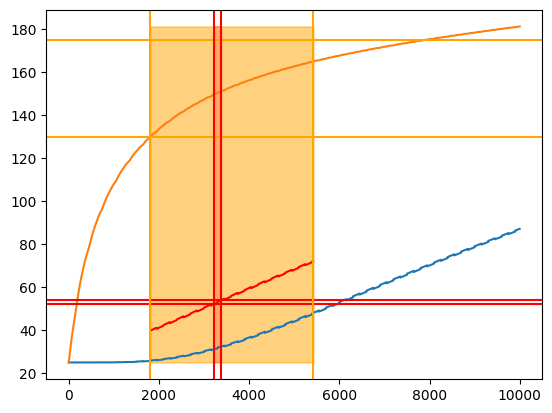

In [81]:
plt.plot(internal_temp)
plt.plot(external_temp)
plt.plot(indices_diluted, res_temp, color="red")
plt.axhline(52,color="red")
plt.axhline(54,color="red")
plt.axhline(130,color="orange")
plt.axhline(175,color="orange")
x_1_external = external_temp.index(min(external_temp, key=lambda x:abs(x-130)))
x_2_external = external_temp.index(min(external_temp, key=lambda x:abs(x-165)))
plt.axvline(x_1_external,color="orange")
plt.axvline(x_2_external,color="orange")
x_1_residual = indices_diluted[res_temp.index(min(res_temp, key=lambda x:abs(x-52)))]
x_2_residual = indices_diluted[res_temp.index(min(res_temp, key=lambda x:abs(x-54)))]
plt.axvline(x_1_residual,color="red")
plt.axvline(x_2_residual,color="red")
plt.fill_between(range(x_1_external,x_2_external),min(external_temp),max(external_temp),color="orange",alpha=.5)
plt.fill_between(range(x_1_residual,x_2_residual),min(external_temp),max(external_temp),color="red",alpha=.2)
plt.show()

## Creating Animation of Heating

In [54]:
arr_copy_two = copy.deepcopy(arr)
arr_copy_two = arr_copy_two[::20]

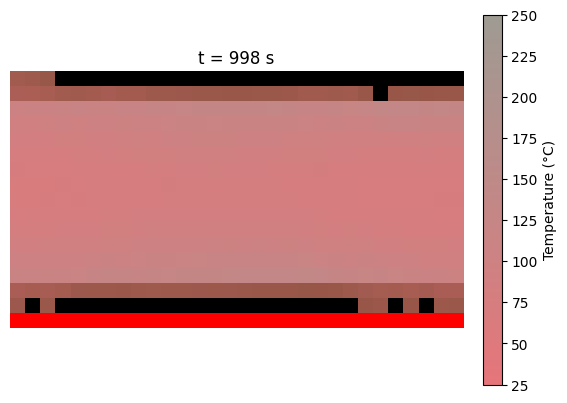

In [76]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors

cmap = mcolors.LinearSegmentedColormap.from_list(
    'temp_map',
    [(0, colors_dict['RAW_COLOR']), (1, colors_dict['INNER_COOKED_COLOR'])]
)

norm = mcolors.Normalize(vmin=room_temperature, vmax=max_temperature)

fig, ax = plt.subplots()

image = ax.imshow(get_color_map(arr_copy_two[0]), animated=True)
ax.axis('off')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Temperature (°C)')

title = ax.set_title("t = 0.0 s")

def update(frame_idx):
    image.set_array(get_color_map(arr_copy_two[frame_idx]))
    time = frame_idx * 2  # each frame = 2 s
    title.set_text(f"t = {time} s")
    return [image, title]

ani = animation.FuncAnimation(
    fig=fig,
    func=update,
    frames=len(arr_copy_two),
    interval=10,         # 10 ms per frame
    repeat_delay=1000,   # pause before looping
    blit=True
)

ani.save("temperature_animation.gif", writer="pillow")
plt.show()


## Composition Map

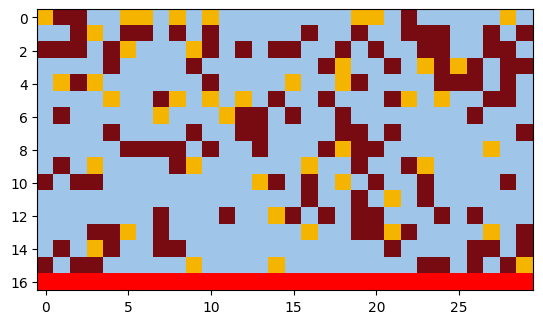

In [87]:
plt.imshow(get_comp_color_map(arr[0]))
plt.savefig("composition.png")